### Packages

In [1]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
import torch.optim.lr_scheduler as lr_scheduler
# This is for the progress bar.
from tqdm.auto import tqdm
import random
from random import shuffle
import math

# cache
from functools import lru_cache

# LunaDataset
import copy

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

In [2]:
# Ground Truth Input

import collections
from collections import namedtuple
import glob
import SimpleITK as sitk
import csv
import functools
from util import XyzTuple, xyz2irc, logging, getCache
from pylidc_func import masks_build

### Ground Truth Input

In [3]:
CandidateInfoTuple = namedtuple('CandidateInfoTuple', 'isNodule_bool, hasAnnotation_bool, isMal_bool, diameter_mm, series_uid, center_xyz, classes')

def getCandidateInfoDict(requireOnDisk_bool=True):  #把candidateInfoList包成Dict
    candidateInfo_list = getCandidateInfoList(requireOnDisk_bool)
    candidateInfo_dict = {}

    for candidateInfo_tup in candidateInfo_list:
        candidateInfo_dict.setdefault(candidateInfo_tup.series_uid,
                                        []).append(candidateInfo_tup)

    return candidateInfo_dict

def getCandidateInfoList(requireOnDisk_bool=True):
    mhd_list = glob.glob('D:/IMProject/LunaData/subset*/*.mhd')
    # mhd_list = glob.glob('D:/IMProject/LunaData/subset0/*.mhd')
    presentOnDisk_set = {os.path.split(p)[-1][:-4] for p in mhd_list}

    candidateInfo_list = []
    with open('D:/IMProject/LunaData/annotations_with_malignancy.csv', "r") as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])
            isMal_bool = {'False': False, 'True': True}[row[5]] #it record the malignancy or not
            classes = 0 if isMal_bool else 1

            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue

            candidateInfo_list.append(
                CandidateInfoTuple(
                    True,
                    True,
                    isMal_bool,
                    annotationDiameter_mm,
                    series_uid,
                    annotationCenter_xyz,
                    classes
                )
            )

#     with open('D:/IMProject/LunaData/candidates_V2.csv', "r") as f:
#         for row in list(csv.reader(f))[1:]:
#             series_uid = row[0]

#             if series_uid not in presentOnDisk_set and requireOnDisk_bool:
#                 continue

#             isNodule_bool = bool(int(row[4]))
#             candidateCenter_xyz = tuple([float(x) for x in row[1:4]])

#             if not isNodule_bool:
#                 candidateInfo_list.append(
#                     CandidateInfoTuple(
#                         False,
#                         False,
#                         False,
#                         0.0,
#                         series_uid,
#                         candidateCenter_xyz,
#                         2
#                     )
#                 )
    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list

In [4]:
class Ct:
    def __init__(self, series_uid):
        mhd_path = glob.glob('D:/IMProject/LunaData/subset*/{}.mhd'.format(series_uid))
        # mhd_path = glob.glob('D:/IMProject/LunaData/subset0/{}.mhd'.format(series_uid))
        # print(mhd_path)

        ct_mhd = sitk.ReadImage(mhd_path)
        if ct_mhd.GetDimension()==4 and ct_mhd.GetSize()[3]==1:
            ct_mhd = ct_mhd[...,0]
        self.hu_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.

        self.series_uid = series_uid
        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)

        self.mask = masks_build(series_uid, self.hu_a)
        
        # candidateInfo_list = candidateInfoDict[self.series_uid]

        # self.positiveInfo_list = [
        #     candidate_tup
        #     for candidate_tup in candidateInfo_list
        #     if candidate_tup.isNodule_bool
        # ] #只將nodule放入list中

    # def getRawFullCT(self, center_xyz, contextSlices_count):
    #     center_irc = xyz2irc(center_xyz, self.origin_xyz, self.vxSize_xyz,
    #                          self.direction_a)
    #     slice_ndx = center_irc.index
    #     ct_a = self.hu_a
    #     pos_a = self.positive_mask

    #     ct_t = torch.zeros((contextSlices_count * 2 + 1, 512, 512))  #預設是上下兩張

    #     start_ndx = slice_ndx - contextSlices_count
    #     end_ndx = slice_ndx + contextSlices_count + 1
    #     for i, context_ndx in enumerate(range(start_ndx, end_ndx)):
    #         context_ndx = max(context_ndx, 0) #避免邊界，遇到邊界會重複
    #         context_ndx = min(context_ndx, ct_a.shape[0] - 1)
    #         ct_t[i] = torch.from_numpy(ct_a[context_ndx].astype(np.float32))

    #     # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
    #     # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.
    #     # The lower bound gets rid of negative density stuff used to indicate out-of-FOV
    #     # The upper bound nukes any weird hotspots and clamps bone down
    #     ct_t.clamp_(-1000, 1000)

    #     pos_t = torch.from_numpy(pos_a[slice_ndx - contextSlices_count : slice_ndx + contextSlices_count + 1])

    #     return ct_t, pos_t, center_irc.index, center_irc.row, center_irc.col
    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(center_xyz, self.origin_xyz, self.vxSize_xyz, self.direction_a)

        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])

            assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr([self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])

            if start_ndx < 0:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                start_ndx = 0
                end_ndx = int(width_irc[axis])

            if end_ndx > self.hu_a.shape[axis]:
                # log.warning("Crop outside of CT array: {} {}, center:{} shape:{} width:{}".format(
                #     self.series_uid, center_xyz, center_irc, self.hu_a.shape, width_irc))
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])

            slice_list.append(slice(start_ndx, end_ndx))

        ct_chunk = self.hu_a[tuple(slice_list)]
        mask_chunk = self.mask[tuple(slice_list)]

        return ct_chunk, center_irc, mask_chunk

In [5]:
# candidateInfoDict = getCandidateInfoDict()
# candi_list = getCandidateInfoList()

# print(candi_list[0])  # CandidateInfoTuple(isNodule_bool=True, hasAnnotation_bool=True, isMal_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.82725575, 85.37992457, -109.74672379999998), classes=0)
# print(len(candi_list))  # 754600

# Dataset

In [6]:
def getCt(series_uid):
    return Ct(series_uid)

def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc, mask_chunk = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc, mask_chunk

class LunaDataset(Dataset):
    def __init__(self,
                 width_irc
                 # val_stride=0,
                 # isValSet_bool=None,
                 # sortby_str='random',
        ):
        self.candidateInfo_list = copy.copy(getCandidateInfoList())
        self.width_irc = width_irc
        self.use_cache = True

        self.series_list = sorted(set(candidateInfo_tup.series_uid for candidateInfo_tup in self.candidateInfo_list))

        # #  如果他是 validation set
        # if isValSet_bool:
        #     assert val_stride > 0, val_stride
        #     self.series_list = self.series_list[::val_stride]
        #     assert self.series_list
        # elif val_stride > 0:
        #     del self.series_list[::val_stride]
        #     assert self.series_list
        # series_set = set(self.series_list)
        # self.candidateInfo_list = [x for x in self.candidateInfo_list if x.series_uid in series_set]

        # #  設定要如何 sort candidate indo list: random, series_uid, label_and_size (default)
        # if sortby_str == 'random':
        #     random.shuffle(self.candidateInfo_list)
        # elif sortby_str == 'series_uid':
        #     self.candidateInfo_list.sort(key=lambda x: (x.series_uid, x.center_xyz))
        # elif sortby_str == 'label_and_size':
        #     pass
        # else:
        #     raise Exception("Unknown sort: " + repr(sortby_str))

        # self.neg_list = \
        #     [nt for nt in self.candidateInfo_list if not nt.isNodule_bool]
        # self.pos_list = \
        #     [nt for nt in self.candidateInfo_list if nt.isNodule_bool]
        # self.ben_list = \
        #     [nt for nt in self.pos_list if not nt.isMal_bool]
        # self.mal_list = \
        #     [nt for nt in self.pos_list if nt.isMal_bool]

        # log.info("{!r}: {} {} samples, {} neg, {} pos, {} ratio".format(
        #     self,
        #     len(self.candidateInfo_list),
        #     "validation" if isValSet_bool else "training",
        #     len(self.neg_list),
        #     len(self.pos_list),
        #     '{}:1'.format(self.ratio_int) if self.ratio_int else 'unbalanced'
        # ))

    # def shuffleSamples(self):
    #     # if self.ratio_int:
    #     random.shuffle(self.candidateInfo_list)
    #     random.shuffle(self.neg_list)
    #     random.shuffle(self.pos_list)
    #     random.shuffle(self.ben_list)
    #     random.shuffle(self.mal_list)

    def __len__(self):
        # if self.ratio_int:
        #     return 50000
        # else:
        return len(self.candidateInfo_list)

    def __getitem__(self, ndx):
        # if self.ratio_int:
        #     pos_ndx = ndx // (self.ratio_int + 1)

        #     if ndx % (self.ratio_int + 1):
        #         neg_ndx = ndx - 1 - pos_ndx
        #         neg_ndx %= len(self.neg_list)
        #         candidateInfo_tup = self.neg_list[neg_ndx]
        #     else:
        #         pos_ndx %= len(self.pos_list)
        #         candidateInfo_tup = self.pos_list[pos_ndx]
        # else:
        
        # candidateInfo_tup = self.candidateInfo_list[ndx]
        
        # return self.sampleFromCandidateInfo_tup(
        #     candidateInfo_tup, candidateInfo_tup.isNodule_bool, candidateInfo_tup.isMal_bool
        # )
        
        ct_chunk = torch.load(f'LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}.pt')
        label_2d = torch.load(f'LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}_label.pt')
        mask_chunk = torch.load(f'LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}_mask.pt')
        # masked_ct = torch.load(f'LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}_maskedCt.pt')
        
        # candidate_t = ct_chunk
        # candidate_t = mask_chunk
        # candidate_t = masked_ct
        candidate_t = torch.cat((ct_chunk, mask_chunk), 0)
        label_t = np.argmax(label_2d)
        # label_t = torch.tensor([np.argmax(label_2d)], dtype=torch.float32)
        
        return candidate_t, label_t
    
    def saveTensor(self):
        true_labels = []
        size = len(self.candidateInfo_list)
        for ndx, candidateInfo_tup in enumerate(self.candidateInfo_list):
            if ndx % 50 == 0:
                print(f"Saving Image [{ndx+1} / {size}] at LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}")
            # candidate_t, label_t, index_t, _, _, mask_t = self.sampleFromCandidateInfo_tup(
            #         candidateInfo_tup, candidateInfo_tup.isNodule_bool, candidateInfo_tup.isMal_bool
            #     )
            candidate_t = torch.load(f'LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}.pt')
            # label_2d = torch.load(f'LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}_label.pt')
            mask_t = torch.load(f'LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}_mask.pt')
            # torch.save(candidate_t, f'LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}.pt')
            # torch.save(label_t, f'LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}_label.pt')
            # torch.save(mask_t, f'LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}_mask.pt')
            # print("c shape =", candidate_t.shape)
            # print("m shape =", mask_t.shape)
            maskedCt = torch.mul(candidate_t, mask_t)
            # print("mc shape =", maskedCt.shape)
            
            torch.save(maskedCt, f'LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}_maskedCt.pt')
            # true_labels.append(index_t)
        print(f"Done saving Image [{size} / {size}] at LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}")
        # return size, np.array(true_labels)
        return

    def loadLabels(self):
        true_labels = []
        size = len(self.candidateInfo_list)
        for ndx in range(size):
            label_t = torch.load(f'LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}_label.pt')
            if ndx % 100 == 0:
                print(f"Loading label [{ndx+1} / {size}] at LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}")
                # print(label_t)
            true_labels.append(np.argmax(label_t))
        print(f"Done loading label [{size} / {size}] at LunaData/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}")
        return size, np.array(true_labels)

    def sampleFromCandidateInfo_tup(self, candidateInfo_tup, isNodule_bool, isMal_bool):
        # width_irc = (1, 64, 64)

        # if self.augmentation_dict:
        #     candidate_t, center_irc = getCtAugmentedCandidate(
        #         self.augmentation_dict,
        #         candidateInfo_tup.series_uid,
        #         candidateInfo_tup.center_xyz,
        #         width_irc,
        #         self.use_cache,
        #     )
        # elif self.use_cache:
        candidate_a, center_irc, mask_a = getCtRawCandidate(
            candidateInfo_tup.series_uid,
            candidateInfo_tup.center_xyz,
            self.width_irc,
        )
        candidate_t = torch.from_numpy(candidate_a).to(torch.float32)
        # print("sfct", candidate_t.shape)
        mask_t = torch.from_numpy(mask_a).to(torch.float32)
        # candidate_t = candidate_t.unsqueeze(0)
        # else:
        #     ct = getCt(candidateInfo_tup.series_uid)
        #     candidate_a, center_irc = ct.getRawCandidate(
        #         candidateInfo_tup.center_xyz,
        #         width_irc,
        #     )
        #     candidate_t = torch.from_numpy(candidate_a).to(torch.float32)
        #     candidate_t = candidate_t.unsqueeze(0)

        label_t = torch.tensor([False, False], dtype=torch.float32)

        # if not isNodule_bool:
        #     label_t[0] = True
        #     index_t = 0
        # else:
        if not isMal_bool:
            label_t[0] = True
            index_t = 0
        else:
            label_t[1] = True
            index_t = 1

        return candidate_t, label_t, index_t, candidateInfo_tup.series_uid, torch.tensor(center_irc), mask_t


# Models

In [7]:
class MyCNN(nn.Module):
    def __init__(self, in_channels=1, out_channels=4):
        super(MyCNN, self).__init__()
        self.cnn = nn.Sequential(
            # conv2d: in channel, out chanel, kernel size, stride, padding
            # max pool: kernel size, stride

            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            # nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 10*31*31
            # nn.MaxPool2d(3, 3), # 10*31*31
            # nn.AvgPool2d(2, 2),
        )

        self.layers = nn.Sequential( # Linear, ReLU, Tanh, Dropout
            nn.Linear(out_channels*32*32, 256),
            # nn.Linear(1600, 256),
            nn.Dropout(0.15),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.15),
            nn.ReLU(),
            nn.Linear(128, 2),
        )

        # self.softmax = nn.Softmax(dim=1)  # default in nn.CrossEntropyLoss()
        
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if type(m) in {
                nn.Linear,
                nn.Conv3d,
                nn.Conv2d,
                nn.ConvTranspose2d,
                nn.ConvTranspose3d,
            }:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                # nn.init.kaiming_normal_(
                #     m.weight.data, a=0, mode='fan_out', nonlinearity='relu'
                # )
                # if m.bias is not None:
                #     fan_in, fan_out = \
                #         nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                #     bound = 1 / math.sqrt(fan_out)
                #     nn.init.normal_(m.bias, -bound, bound)

    def forward(self, x):
        x = self.cnn(x)
        x = torch.flatten(x, 1)
        x = self.layers(x)
        return x

In [8]:
class LunaModel(nn.Module):
    def __init__(self, in_channels=1, conv_channels=8):
        super().__init__()

        self.tail_batchnorm = nn.BatchNorm2d(in_channels)

        self.block1 = LunaBlock(in_channels, conv_channels)
        self.block2 = LunaBlock(conv_channels, conv_channels * 2)
        self.block3 = LunaBlock(conv_channels * 2, conv_channels * 4)
        self.block4 = LunaBlock(conv_channels * 4, conv_channels * 8)

        self.head_linear = nn.Linear(conv_channels*128, 2)
        # self.head_activation = nn.Softmax(dim=1)  # default in nn.CrossEntropyLoss()

        self._init_weights()

    # see also https://github.com/pytorch/pytorch/issues/18182
    def _init_weights(self):
        for m in self.modules():
            if type(m) in {
                nn.Linear,
                nn.Conv3d,
                nn.Conv2d,
                nn.ConvTranspose2d,
                nn.ConvTranspose3d,
            }:
                nn.init.kaiming_normal_(
                    m.weight.data, a=0, mode='fan_out', nonlinearity='relu'
                )
                if m.bias is not None:
                    fan_in, fan_out = \
                        nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                    bound = 1 / math.sqrt(fan_out)
                    nn.init.normal_(m.bias, -bound, bound)


    def forward(self, input_batch):
        # print("input_batch :", input_batch.shape)
        bn_output = self.tail_batchnorm(input_batch)
        # print("bn_output :", bn_output.shape)

        block_out = self.block1(bn_output)
        block_out = self.block2(block_out)
        block_out = self.block3(block_out)
        block_out = self.block4(block_out)

        # print("block_out 0 :", block_out.shape)

        conv_flat = block_out.view(
            block_out.size(0),
            -1,
        )
        linear_output = self.head_linear(conv_flat)

        return linear_output


class LunaBlock(nn.Module):
    def __init__(self, in_channels, conv_channels):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, conv_channels, kernel_size=3, padding=1, bias=True
        )
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            conv_channels, conv_channels, kernel_size=3, padding=1, bias=True
        )
        self.relu2 = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(2, 2)

    def forward(self, input_batch):
        block_out = self.conv1(input_batch)
        # print("block_out 1 :", block_out.shape)
        block_out = self.relu1(block_out)
        # print("block_out 2 :", block_out.shape)
        block_out = self.conv2(block_out)
        # print("block_out 3 :", block_out.shape)
        block_out = self.relu2(block_out)
        # print("block_out 4 :", block_out.shape)

        return self.maxpool(block_out)

In [3]:
class ResidualNetwork18(nn.Module):
    def __init__(self, in_channels=1, out_channels=8):
        super(ResidualNetwork18, self).__init__()
        
        self.tail_batchnorm = nn.BatchNorm2d(in_channels)

        self.conv33 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1, bias=True
        )

        self.block1 = ResidualBlock(out_channels)
        self.block2 = ResidualBlock(2*out_channels)
        self.block3 = ResidualBlock(4*out_channels)
        self.block4 = ResidualBlock(8*out_channels)
        # self.block5 = ResidualBlock(16*out_channels)

        self.conv11 = nn.Conv2d(
            # 8*out_channels, 1, kernel_size=1, bias=True
            16*out_channels, 1, kernel_size=1, bias=True
            # 32*out_channels, 1, kernel_size=1, bias=True
        )

        self.maxpool = nn.MaxPool2d(2, 2)
        # self.avgpool = nn.AvgPool2d(12, 12)

        # self.head_linear = nn.Linear(64, 1)
        self.head_linear = nn.Linear(64, 2)
        # self.head_linear = nn.Linear(16, 2)
        # self.softmax = nn.Softmax(dim=1)  # default in nn.CrossEntropyLoss()
        
        # weights initialization
        torch.nn.init.xavier_uniform_(self.conv33.weight)
        torch.nn.init.xavier_uniform_(self.conv11.weight)
        torch.nn.init.xavier_uniform_(self.head_linear.weight)

    def forward(self, x):
        # print("input :", x.shape)
        output = self.tail_batchnorm(x)
        output = self.conv33(output)
        # print("conv_out 33 :", output.shape)
        output = self.block1(output)
        # print("block_out 1 :", output.shape)
        output = self.maxpool(output)
        # print("max_out 1 :", output.shape)
        output = self.block2(output)
        output = self.maxpool(output)
        # print("max_out 2 :", output.shape)
        output = self.block3(output)
        output = self.maxpool(output)
        # print("max_out 3 :", output.shape)
        output = self.block4(output)  # new
        # output = self.maxpool(output)
        # print("max_out 4 :", output.shape)
        # output = self.block5(output)  # new
        # output = self.maxpool(output)
        # print("max_out 4 :", output.shape)
        output = self.conv11(output)
        # print("conv_out 11 :", output.shape)

        # output = self.avgpool(output)
        output = self.head_linear(output.view(output.size(0),-1,))
        return output
        # return torch.squeeze(output)

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.batchnorm = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv = nn.Conv2d(
            in_channels, in_channels, kernel_size=3, padding=1, bias=True
        )
        
        # weights initialization
        torch.nn.init.xavier_uniform_(self.conv.weight)

    def forward(self, x):
        output = self.batchnorm(x)
        output = self.relu(output)
        output = self.conv(output)

        output = self.batchnorm(x)
        output = self.relu(output)
        output = self.conv(output)

        return torch.cat((x, output), 1)

# Training

In [10]:
myseed = 42  # set a random seed for reproducibility
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#This flag allows you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

cuda


In [11]:
width_irc = (1, 64, 64)
full_dataset = LunaDataset(width_irc)
# full_dataset.saveTensor()
n_samples, true_labels = full_dataset.loadLabels()

Loading label [1 / 1182] at LunaData/1_64_64
Loading label [101 / 1182] at LunaData/1_64_64
Loading label [201 / 1182] at LunaData/1_64_64
Loading label [301 / 1182] at LunaData/1_64_64
Loading label [401 / 1182] at LunaData/1_64_64
Loading label [501 / 1182] at LunaData/1_64_64
Loading label [601 / 1182] at LunaData/1_64_64
Loading label [701 / 1182] at LunaData/1_64_64
Loading label [801 / 1182] at LunaData/1_64_64
Loading label [901 / 1182] at LunaData/1_64_64
Loading label [1001 / 1182] at LunaData/1_64_64
Loading label [1101 / 1182] at LunaData/1_64_64
Done loading label [1182 / 1182] at LunaData/1_64_64


In [12]:
print(f"Mal: {sum(true_labels)} / All: {n_samples}")  # 378 / 1182

Mal: 378 / All: 1182


In [13]:
num_fold = 5
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=myseed)
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=myseed)

num_epoch = 50
batch_size = 256

In [14]:
# train + valid, test split
train_val_dataset = None
train_val_labels = None
test_dataset = None
for train_val_index, test_index in sss.split(np.zeros(n_samples), true_labels):
    train_val_dataset = Subset(full_dataset, train_val_index)
    test_dataset = Subset(full_dataset, test_index)
    train_val_labels = true_labels[train_val_index]
    test_true_labels = true_labels[test_index]
train_val_n_samples = len(train_val_labels)

In [15]:
print(f"Mal: {sum(train_val_labels)} / All: {train_val_n_samples}")  # 340 / 1063

Mal: 340 / All: 1063


In [16]:
# training with five-fold cross validation

best_loss = math.inf
best_fold = 0
best_epoch = 0
best_accuracy = 0
best_precision = 0
best_recall = 0
best_f1score = 0
best_pred_mal_num = 0
best_true_mal_num = 0
best_all_num = 0
trains_loss = []
valids_loss = []
all_labels = []
all_preds = []

for fold_i, (train_index, val_index) in enumerate(skf.split(np.zeros(train_val_n_samples), train_val_labels)):  # skf.split(X, y)
    torch.manual_seed(myseed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(myseed)
    # model = MyCNN()
    # model = MyCNN(in_channels=2, out_channels=8)
    # model = LunaModel()
    # model = LunaModel(in_channels=2, conv_channels=8)
    # model = ResidualNetwork18()
    model = ResidualNetwork18(in_channels=2, out_channels=8)
    
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    
    # sigmoid = nn.Sigmoid()
    
    # optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay=0.0001)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

    # scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=50)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    # train_dataset = Subset(full_dataset, train_index)
    # valid_dataset = Subset(full_dataset, val_index)
    
    train_dataset = Subset(train_val_dataset, train_index)
    valid_dataset = Subset(train_val_dataset, val_index)
    train_true_labels = train_val_labels[train_index]
    valid_true_labels = train_val_labels[val_index]
    print(f"Fold [{fold_i + 1} / {num_fold}] Training Mal: {sum(train_true_labels)} / All: {len(train_true_labels)}, Validating  Mal: {sum(valid_true_labels)} / All: {len(valid_true_labels)}")
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    
    trains_loss.append([])
    valids_loss.append([])
    fold_best_loss = math.inf
    fold_best_preds = []
    for epoch in range(num_epoch): # epoch
        model.train()
        loss_record = []
        train_true_labels = []
        train_preds = []
        # fold_labels = []
        fold_preds = []
        size = len(train_dataloader.dataset)
        dl_size = len(train_dataloader)
        for i, (candidate_t, label_t) in enumerate(train_dataloader):
            # print("x shape :", candidate_t.shape)
            candidate_t, label_t = candidate_t.to(device), label_t.to(device)
            optimizer.zero_grad()
            pred = model(candidate_t)
            # print(f'for {i} pred: {pred}\n')
            # print(f'for {i} label_t: {label_t}\n')
            train_true_labels.extend(label_t.cpu().numpy())
            train_preds.extend(np.argmax(pred.cpu().detach().numpy(), axis=1))
            # train_preds.extend(np.round(sigmoid(pred).cpu().detach().numpy()))
            loss = loss_fn(pred, label_t)
            # loss = torchvision.ops.sigmoid_focal_loss(pred, label_t.float(), reduction='mean')
            # print(f'for {i} loss: {loss.item}\n')
            loss_record.append(loss.item())
            loss.backward() # backpropagation
            optimizer.step()
        before_lr = optimizer.param_groups[0]["lr"]
        scheduler.step()
        after_lr = optimizer.param_groups[0]["lr"]
        print(f'Fold [{fold_i + 1} / {num_fold}] Epoch [{epoch + 1} / {num_epoch}]: Learning Rate changing from {before_lr} to {after_lr}')
        mean_train_loss = sum(loss_record) / len(loss_record)
        trains_loss[fold_i].append(mean_train_loss)
        # print("train_labels =", train_true_labels)
        # print("train_preds =", train_preds)
        train_accuracy = accuracy_score(train_true_labels, train_preds)
        train_precision = precision_score(train_true_labels, train_preds, average='weighted')
        train_recall = recall_score(train_true_labels, train_preds, average='weighted')
        train_f1score = f1_score(train_true_labels, train_preds, average='weighted')
        # print(f'Fold [{fold_i + 1} / {num_fold}] Epoch [{epoch + 1} / {num_epoch}]: Train loss: {mean_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, Predict Mal: {sum(train_preds)} / {sum(train_labels)}')

        model.eval()
        loss_record = []
        for x, y in valid_dataloader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = loss_fn(pred, y)
                # loss = torchvision.ops.sigmoid_focal_loss(pred, y.float(), reduction='mean')
                # fold_labels.extend(np.argmax(y.cpu().numpy(), axis=1))
                fold_preds.extend(np.argmax(pred.cpu().numpy(), axis=1))
                # fold_preds.extend(np.round(sigmoid(pred).cpu().detach().numpy()))
            loss_record.append(loss.item())
        mean_valid_loss = sum(loss_record) / len(loss_record)
        valids_loss[fold_i].append(mean_valid_loss)
        valid_accuracy = accuracy_score(valid_true_labels, fold_preds)
        valid_precision = precision_score(valid_true_labels, fold_preds, average='weighted')
        valid_recall = recall_score(valid_true_labels, fold_preds, average='weighted')
        valid_f1score = f1_score(valid_true_labels, fold_preds, average='weighted')
        print(f'''Fold [{fold_i + 1} / {num_fold}] Epoch [{epoch + 1} / {num_epoch}]: Train loss: {mean_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-score: {train_f1score:.4f}, Predict Mal: {sum(train_preds)} / {sum(train_true_labels)}, All: {len(train_true_labels)}
                               Valid loss: {mean_valid_loss:.4f}, Accuracy: {valid_accuracy:.4f}, Precision: {valid_precision:.4f}, Recall: {valid_recall:.4f}, F1-score: {valid_f1score:.4f}, Predict Mal: {sum(fold_preds)} / {sum(valid_true_labels)}, All: {len(valid_true_labels)}''')

        if mean_valid_loss < fold_best_loss:
            fold_best_loss = mean_valid_loss
            fold_best_preds = fold_preds
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            best_fold = fold_i + 1
            best_epoch = epoch + 1
            best_accuracy = valid_accuracy
            best_precision = valid_precision
            best_recall = valid_recall
            best_f1score = valid_f1score
            best_pred_mal_num = sum(fold_preds)
            best_true_mal_num = sum(valid_true_labels)
            best_all_num = len(valid_true_labels)
            # torch.save(model.state_dict(), 'classification_Simple.pth')
            # torch.save(model.state_dict(), 'classification_DoubleCNN.pth')
            torch.save(model.state_dict(), 'classification_ResNet.pth')
            print('Saving model with loss {:.4f}...'.format(best_loss))
    
    all_labels.extend(valid_true_labels)
    all_preds.extend(fold_best_preds)
            
overall_precision = precision_score(all_labels, all_preds, average='weighted')
overall_recall = recall_score(all_labels, all_preds, average='weighted')
overall_f1score = f1_score(all_labels, all_preds, average='weighted')
print(f"\nOverall Precision: {overall_precision:.4f}, Recall: {overall_recall:.4f}")
print(f"Saved Model at Fold [{best_fold} / {num_fold}] Epoch [{best_epoch} / {num_epoch}] with Valid loss: {best_loss:.4f}, Accuracy: {best_accuracy:.4f}, Precision: {best_precision:.4f}, Recall: {best_recall:.4f}, F1-score: {best_f1score:.4f}, Predicted Mal: {best_pred_mal_num} / {best_true_mal_num}, All: {best_all_num}")

Fold [1 / 5] Training Mal: 272 / All: 850, Validating  Mal: 68 / All: 213
Fold [1 / 5] Epoch [1 / 50]: Leaning Rate changing from 0.001 to 0.00099


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold [1 / 5] Epoch [1 / 50]: Train loss: 0.5261, Accuracy: 0.7694, Precision: 0.7713, Recall: 0.7694, F1-score: 0.7703, Predict Mal: 280 / 272, All: 850
                               Valid loss: 1.1201, Accuracy: 0.6808, Precision: 0.4634, Recall: 0.6808, F1-score: 0.5514, Predict Mal: 0 / 68, All: 213
Saving model with loss 1.1201...
Fold [1 / 5] Epoch [2 / 50]: Leaning Rate changing from 0.00099 to 0.0009801
Fold [1 / 5] Epoch [2 / 50]: Train loss: 0.4492, Accuracy: 0.8071, Precision: 0.8061, Recall: 0.8071, F1-score: 0.7945, Predict Mal: 180 / 272, All: 850
                               Valid loss: 0.7574, Accuracy: 0.6808, Precision: 0.6242, Recall: 0.6808, F1-score: 0.5598, Predict Mal: 2 / 68, All: 213
Saving model with loss 0.7574...
Fold [1 / 5] Epoch [3 / 50]: Leaning Rate changing from 0.0009801 to 0.000970299
Fold [1 / 5] Epoch [3 / 50]: Train loss: 0.4018, Accuracy: 0.8329, Precision: 0.8356, Recall: 0.8329, F1-score: 0.8340, Predict Mal: 286 / 272, All: 850
             

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold [2 / 5] Epoch [1 / 50]: Train loss: 0.4781, Accuracy: 0.7729, Precision: 0.7776, Recall: 0.7729, F1-score: 0.7749, Predict Mal: 291 / 272, All: 850
                               Valid loss: 1.1700, Accuracy: 0.6808, Precision: 0.4634, Recall: 0.6808, F1-score: 0.5514, Predict Mal: 0 / 68, All: 213
Fold [2 / 5] Epoch [2 / 50]: Leaning Rate changing from 0.00099 to 0.0009801


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold [2 / 5] Epoch [2 / 50]: Train loss: 0.4758, Accuracy: 0.7929, Precision: 0.7924, Recall: 0.7929, F1-score: 0.7766, Predict Mal: 166 / 272, All: 850
                               Valid loss: 0.7950, Accuracy: 0.6808, Precision: 0.4634, Recall: 0.6808, F1-score: 0.5514, Predict Mal: 0 / 68, All: 213
Fold [2 / 5] Epoch [3 / 50]: Leaning Rate changing from 0.0009801 to 0.000970299
Fold [2 / 5] Epoch [3 / 50]: Train loss: 0.4070, Accuracy: 0.8353, Precision: 0.8412, Recall: 0.8353, F1-score: 0.8373, Predict Mal: 300 / 272, All: 850
                               Valid loss: 0.6649, Accuracy: 0.6854, Precision: 0.7849, Recall: 0.6854, F1-score: 0.5622, Predict Mal: 1 / 68, All: 213
Fold [2 / 5] Epoch [4 / 50]: Leaning Rate changing from 0.000970299 to 0.0009605960099999999
Fold [2 / 5] Epoch [4 / 50]: Train loss: 0.3525, Accuracy: 0.8494, Precision: 0.8469, Recall: 0.8494, F1-score: 0.8458, Predict Mal: 230 / 272, All: 850
                               Valid loss: 0.6141, Accuracy: 0.

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold [3 / 5] Epoch [1 / 50]: Train loss: 0.5231, Accuracy: 0.7518, Precision: 0.7535, Recall: 0.7518, F1-score: 0.7526, Predict Mal: 279 / 272, All: 850
                               Valid loss: 1.0610, Accuracy: 0.6808, Precision: 0.4634, Recall: 0.6808, F1-score: 0.5514, Predict Mal: 0 / 68, All: 213
Fold [3 / 5] Epoch [2 / 50]: Leaning Rate changing from 0.00099 to 0.0009801


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold [3 / 5] Epoch [2 / 50]: Train loss: 0.4561, Accuracy: 0.7894, Precision: 0.7829, Recall: 0.7894, F1-score: 0.7807, Predict Mal: 207 / 272, All: 850
                               Valid loss: 0.7162, Accuracy: 0.6808, Precision: 0.4634, Recall: 0.6808, F1-score: 0.5514, Predict Mal: 0 / 68, All: 213
Fold [3 / 5] Epoch [3 / 50]: Leaning Rate changing from 0.0009801 to 0.000970299


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold [3 / 5] Epoch [3 / 50]: Train loss: 0.4360, Accuracy: 0.8165, Precision: 0.8207, Recall: 0.8165, F1-score: 0.8181, Predict Mal: 292 / 272, All: 850
                               Valid loss: 0.6224, Accuracy: 0.6808, Precision: 0.4634, Recall: 0.6808, F1-score: 0.5514, Predict Mal: 0 / 68, All: 213
Fold [3 / 5] Epoch [4 / 50]: Leaning Rate changing from 0.000970299 to 0.0009605960099999999
Fold [3 / 5] Epoch [4 / 50]: Train loss: 0.4277, Accuracy: 0.8376, Precision: 0.8347, Recall: 0.8376, F1-score: 0.8330, Predict Mal: 224 / 272, All: 850
                               Valid loss: 0.5277, Accuracy: 0.7230, Precision: 0.8031, Recall: 0.7230, F1-score: 0.6403, Predict Mal: 9 / 68, All: 213
Fold [3 / 5] Epoch [5 / 50]: Leaning Rate changing from 0.0009605960099999999 to 0.0009509900498999999
Fold [3 / 5] Epoch [5 / 50]: Train loss: 0.3702, Accuracy: 0.8518, Precision: 0.8503, Recall: 0.8518, F1-score: 0.8469, Predict Mal: 218 / 272, All: 850
                               Valid loss

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold [5 / 5] Epoch [1 / 50]: Train loss: 0.5139, Accuracy: 0.7591, Precision: 0.7618, Recall: 0.7591, F1-score: 0.7603, Predict Mal: 283 / 272, All: 851
                               Valid loss: 1.1374, Accuracy: 0.6792, Precision: 0.4614, Recall: 0.6792, F1-score: 0.5495, Predict Mal: 0 / 68, All: 212
Fold [5 / 5] Epoch [2 / 50]: Leaning Rate changing from 0.00099 to 0.0009801


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold [5 / 5] Epoch [2 / 50]: Train loss: 0.4649, Accuracy: 0.7885, Precision: 0.7829, Recall: 0.7885, F1-score: 0.7763, Predict Mal: 188 / 272, All: 851
                               Valid loss: 0.7607, Accuracy: 0.6792, Precision: 0.4614, Recall: 0.6792, F1-score: 0.5495, Predict Mal: 0 / 68, All: 212
Fold [5 / 5] Epoch [3 / 50]: Leaning Rate changing from 0.0009801 to 0.000970299
Fold [5 / 5] Epoch [3 / 50]: Train loss: 0.4240, Accuracy: 0.8190, Precision: 0.8218, Recall: 0.8190, F1-score: 0.8202, Predict Mal: 286 / 272, All: 851
                               Valid loss: 0.6234, Accuracy: 0.6840, Precision: 0.7843, Recall: 0.6840, F1-score: 0.5603, Predict Mal: 1 / 68, All: 212
Fold [5 / 5] Epoch [4 / 50]: Leaning Rate changing from 0.000970299 to 0.0009605960099999999
Fold [5 / 5] Epoch [4 / 50]: Train loss: 0.4007, Accuracy: 0.8367, Precision: 0.8334, Recall: 0.8367, F1-score: 0.8332, Predict Mal: 235 / 272, All: 851
                               Valid loss: 0.5114, Accuracy: 0.

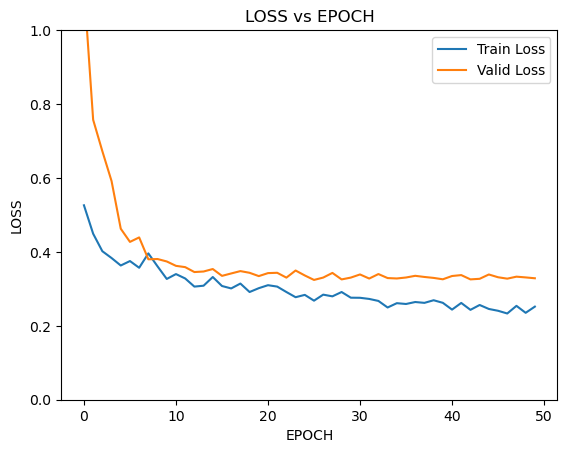

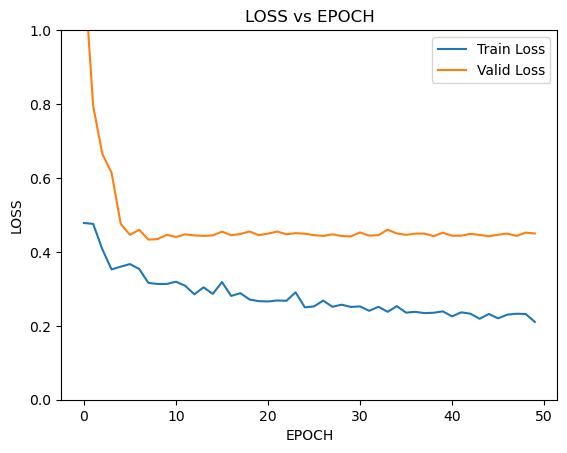

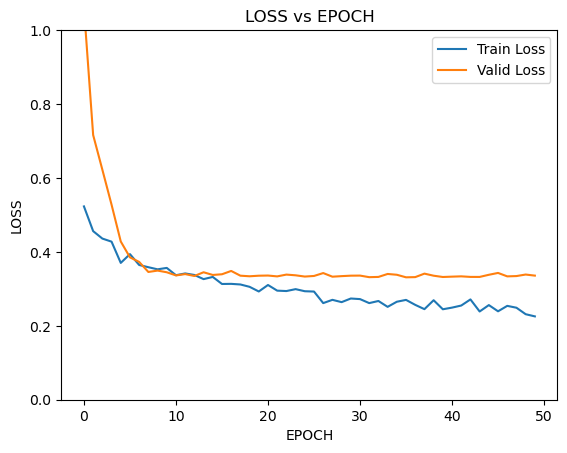

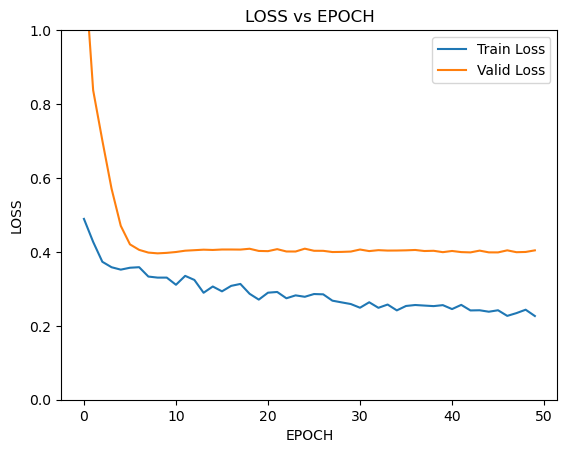

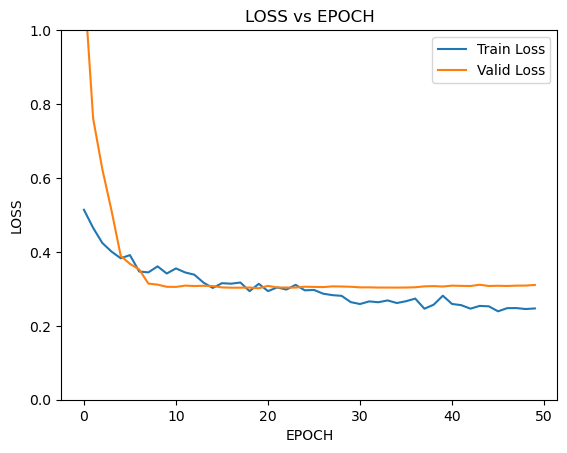

In [17]:
# loss plot
for i in range(num_fold):
    plt.plot(range(num_epoch), trains_loss[i], label='Train Loss')
    plt.plot(range(num_epoch), valids_loss[i], label='Valid Loss')
    plt.ylim(0.0, 1.0)
    plt.title('LOSS vs EPOCH')
    plt.xlabel('EPOCH')
    plt.ylabel('LOSS')
    plt.legend()
    plt.show()

Test Loss: 0.3048, Accuracy: 0.9076, Precision: 0.9070, Recall: 0.9076, F1-score: 0.9072, Predict Mal: 37 / 38 / All: 119


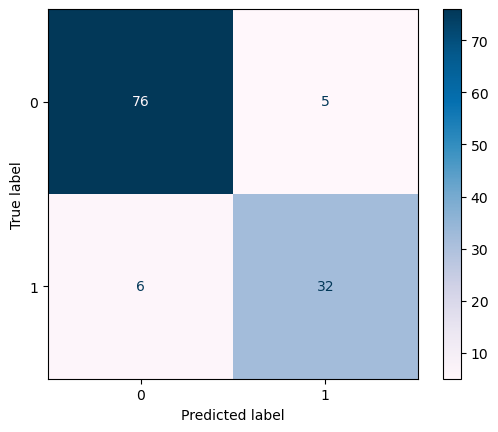

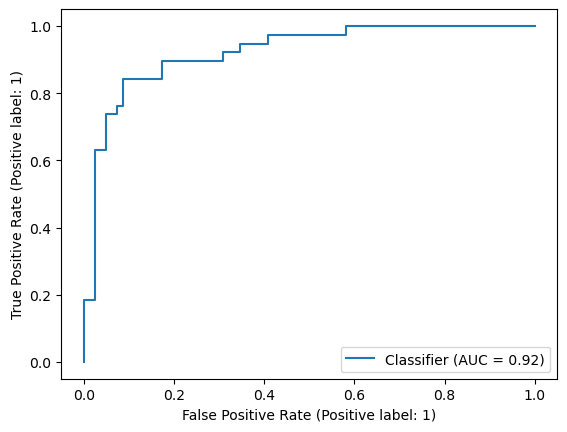

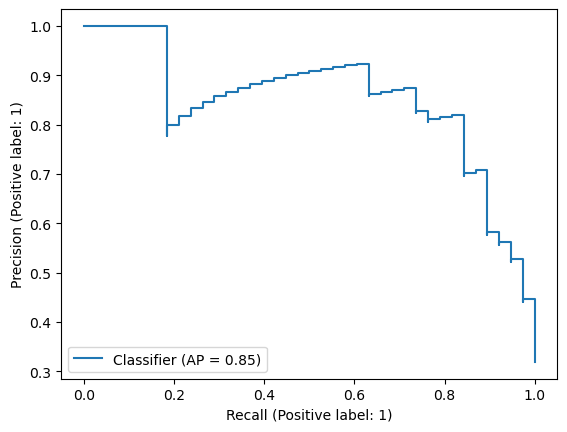

In [19]:
# predict test dataset
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)


# model_best = MyCNN()
# model_best = MyCNN(in_channels=2, out_channels=8)
# model_best = LunaModel()
# model_best = LunaModel(in_channels=2, conv_channels=8)
# model_best = ResidualNetwork18()
model_best = ResidualNetwork18(in_channels=2, out_channels=8)

# model_best.load_state_dict(torch.load('classification_Simple.pth'))
# model_best.load_state_dict(torch.load('classification_DoubleCNN.pth'))
model_best.load_state_dict(torch.load('classification_ResNet.pth'))
model_best.eval()
model_best.to(device)
loss_fn = nn.CrossEntropyLoss()
sigmoid = nn.Sigmoid()
test_true_labels = []
test_class_preds = []
test_prob_preds = []
test_loss_record = []
for x, y in test_dataloader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        pred = model_best(x)
        loss = loss_fn(pred, y)
        # loss = torchvision.ops.sigmoid_focal_loss(pred, y.float(), reduction='mean')

        # print(f'for {i} pred: {pred}\n')
        # print(f'for {i} label_t: {y}\n')
        test_true_labels.extend(y.cpu().numpy())
        test_loss_record.append(loss.item())
        test_class_preds.extend(np.argmax(pred.cpu().numpy(), axis=1))
        test_prob_preds.extend(sigmoid(pred).cpu().numpy()[:,1])
        # test_prob_preds.extend(pred.cpu().numpy()[:,1])
        # test_preds.extend(np.round(sigmoid(pred).cpu().detach().numpy()))

mean_test_loss = sum(test_loss_record) / len(test_loss_record)
test_accuracy = accuracy_score(test_true_labels, test_class_preds)
test_precision = precision_score(test_true_labels, test_class_preds, average='weighted')
test_recall = recall_score(test_true_labels, test_class_preds, average='weighted')
test_f1score = f1_score(test_true_labels, test_class_preds, average='weighted')
print(f'Test Loss: {mean_test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1score:.4f}, Predict Mal: {sum(test_class_preds)} / {sum(test_true_labels)} / All: {len(test_true_labels)}')

ConfusionMatrixDisplay.from_predictions(test_true_labels, test_class_preds, cmap="PuBu")
RocCurveDisplay.from_predictions(test_true_labels, test_prob_preds)
PrecisionRecallDisplay.from_predictions(test_true_labels, test_prob_preds)
plt.show()

# Detection Test Dataset

In [20]:
class DetectionDataset(Dataset):
    def __init__(self,
                 width_irc
                 # val_stride=0,
                 # isValSet_bool=None,
                 # sortby_str='random',
        ):
        self.width_irc = width_irc

    def __len__(self):
        return 785

    def __getitem__(self, ndx):
        ct_chunk = torch.load(f'DetectionTest/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}.pt')
        label_2d = torch.load(f'DetectionTest/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}_label.pt')
        mask_chunk = torch.load(f'DetectionTest/{self.width_irc[0]}_{self.width_irc[1]}_{self.width_irc[2]}/{ndx}_mask.pt')
        
        # candidate_t = ct_chunk
        # candidate_t = mask_chunk
        # candidate_t = masked_ct
        candidate_t = torch.cat((ct_chunk, mask_chunk), 0)
        label_t = np.argmax(label_2d)
        # label_t = torch.tensor([np.argmax(label_2d)], dtype=torch.float32)
        
        return candidate_t, label_t

In [30]:
dtest_widthirc = (1, 64, 64)
dtestDS = DetectionDataset(dtest_widthirc)
dtest_dataloader = DataLoader(dtestDS, batch_size = 192, shuffle = False)

Test Loss: 0.4455, Accuracy: 0.7541, Precision: 0.7679, Recall: 0.7541, F1-score: 0.7493, Predict Mal: 283 / 378 / All: 785


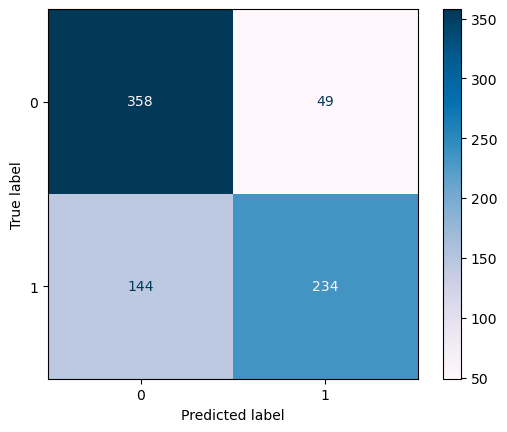

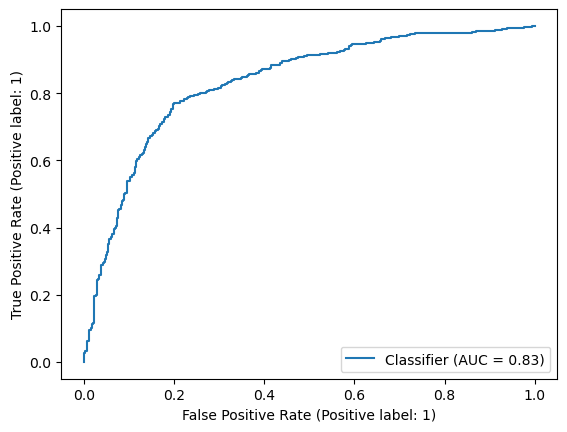

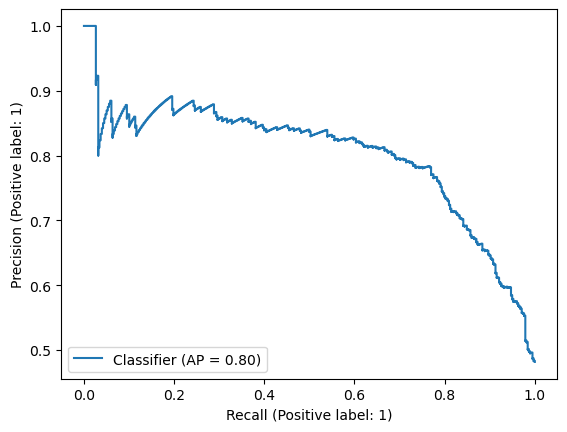

In [40]:
dmodel_best = ResidualNetwork18(in_channels=2, out_channels=8)
# dmodel_best = MyCNN(in_channels=2, out_channels=8)
dmodel_best.load_state_dict(torch.load('classification_ResNet_3071_9072_128nomax_5fold256batch_SGDlr5-4wd1-3exp99_42.pth'))

dmodel_best.eval()
dmodel_best.to(device)
dloss_fn = nn.CrossEntropyLoss()
# dsoftmax = nn.Softmax(dim=1)
dsigmoid = nn.Sigmoid()
dtest_true_labels = []
dtest_class_preds = []
dtest_prob_preds = []
dtest_loss_record = []
for x, y in dtest_dataloader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        pred = dmodel_best(x)
        loss = dloss_fn(pred, y)
        # loss = torchvision.ops.sigmoid_focal_loss(pred, y.float(), reduction='mean')

        # print(f'for {i} pred: {pred}\n')
        # print(f'for {i} label_t: {y}\n')
        dtest_true_labels.extend(y.cpu().numpy())
        dtest_loss_record.append(loss.item())
        dtest_class_preds.extend(np.argmax(pred.cpu().numpy(), axis=1))
        dtest_prob_preds.extend(dsigmoid(pred).cpu().numpy()[:,1])
        # dtest_prob_preds.extend(pred.cpu().numpy()[:,1])
        # dtest_preds.extend(np.round(sigmoid(pred).cpu().detach().numpy()))

mean_dtest_loss = sum(dtest_loss_record) / len(dtest_loss_record)
dtest_accuracy = accuracy_score(dtest_true_labels, dtest_class_preds)
dtest_precision = precision_score(dtest_true_labels, dtest_class_preds, average='weighted')
# dtest_precision = precision_score(dtest_true_labels, dtest_class_preds)
dtest_recall = recall_score(dtest_true_labels, dtest_class_preds, average='weighted')
dtest_f1score = f1_score(dtest_true_labels, dtest_class_preds, average='weighted')
print(f'Test Loss: {mean_dtest_loss:.4f}, Accuracy: {dtest_accuracy:.4f}, Precision: {dtest_precision:.4f}, Recall: {dtest_recall:.4f}, F1-score: {dtest_f1score:.4f}, Predict Mal: {sum(dtest_class_preds)} / {sum(dtest_true_labels)} / All: {len(dtest_true_labels)}')

ConfusionMatrixDisplay.from_predictions(dtest_true_labels, dtest_class_preds, cmap="PuBu")
RocCurveDisplay.from_predictions(dtest_true_labels, dtest_prob_preds)
PrecisionRecallDisplay.from_predictions(dtest_true_labels, dtest_prob_preds)
plt.show()

In [41]:
precision_score(dtest_true_labels, dtest_class_preds)

0.8268551236749117

In [42]:
recall_score(dtest_true_labels, dtest_class_preds)

0.6190476190476191

In [43]:
f1_score(dtest_true_labels, dtest_class_preds)

0.708018154311649

### Detection Data Dataset

In [4]:
class DetectionDataDataset(Dataset):
    def __init__(self,
                 TrainValidTest
        ):
        self.TrainValidTest = TrainValidTest
        self.all_ct = glob.glob('D:/IMProject/DetectionData/{}/*_ct.pt'.format(self.TrainValidTest))
        self.all_mask = glob.glob('D:/IMProject/DetectionData/{}/*_mask.pt'.format(self.TrainValidTest))
        self.all_label = glob.glob('D:/IMProject/DetectionData/{}/*_label.pt'.format(self.TrainValidTest))

    def __len__(self):
        return len(self.all_ct)

    def __getitem__(self, ndx):
        ct_chunk = torch.load(self.all_ct[ndx])
        label_2d = torch.load(self.all_label[ndx])
        mask_chunk = torch.load(self.all_mask[ndx])
        
        # candidate_t = ct_chunk
        # candidate_t = mask_chunk
        # candidate_t = masked_ct
        candidate_t = torch.cat((ct_chunk, mask_chunk), 0)
        label_t = np.argmax(label_2d)
        # label_t = torch.tensor([np.argmax(label_2d)], dtype=torch.float32)
        
        return candidate_t, label_t

In [5]:
myseed = 42  # set a random seed for reproducibility
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
#This flag allows you to enable the inbuilt cudnn auto-tuner to find the best algorithm to use for your hardware.
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

cuda


In [6]:
trainDDDS = DetectionDataDataset("Train")
validDDDS = DetectionDataDataset("Valid")

In [7]:
batch_size = 256
num_epoch = 50

In [8]:
len(trainDDDS) # 37914

37962

In [9]:
len(validDDDS) # 789

789

In [12]:
best_loss = math.inf
best_epoch = 0
best_accuracy = 0
best_precision = 0
best_recall = 0
best_f1score = 0
best_pred_mal_num = 0
best_true_mal_num = 0
best_all_num = 0
trains_loss = []
valids_loss = []

torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)
model = ResidualNetwork18(in_channels=2, out_channels=8)

model.to(device)
loss_fn = nn.CrossEntropyLoss()

# sigmoid = nn.Sigmoid()

# optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay=0.0001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=50)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

# print(f"Training Mal: {sum(train_true_labels)} / All: {len(train_true_labels)}, Validating  Mal: {sum(valid_true_labels)} / All: {len(valid_true_labels)}")

train_dataloader = DataLoader(trainDDDS, batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(validDDDS, batch_size=batch_size, shuffle=False)

fold_best_loss = math.inf
fold_best_preds = []
for epoch in range(num_epoch): # epoch
    model.train()
    loss_record = []
    train_true_labels = []
    train_preds = []
    valid_true_labels = []
    fold_preds = []
    size = len(train_dataloader.dataset)
    dl_size = len(train_dataloader)
    for i, (candidate_t, label_t) in enumerate(train_dataloader):
        # print("x shape :", candidate_t.shape)
        candidate_t, label_t = candidate_t.to(device), label_t.to(device)
        optimizer.zero_grad()
        pred = model(candidate_t)
        # print(f'for {i} pred: {pred}\n')
        # print(f'for {i} label_t: {label_t}\n')
        train_true_labels.extend(label_t.cpu().numpy())
        train_preds.extend(np.argmax(pred.cpu().detach().numpy(), axis=1))
        # train_preds.extend(np.round(sigmoid(pred).cpu().detach().numpy()))
        loss = loss_fn(pred, label_t)
        # loss = torchvision.ops.sigmoid_focal_loss(pred, label_t.float(), reduction='mean')
        # print(f'for {i} loss: {loss.item}\n')
        loss_record.append(loss.item())
        loss.backward() # backpropagation
        optimizer.step()
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print(f'Epoch [{epoch + 1} / {num_epoch}]: Learning Rate changing from {before_lr} to {after_lr}')
    mean_train_loss = sum(loss_record) / len(loss_record)
    trains_loss.append(mean_train_loss)
    # print("train_labels =", train_true_labels)
    # print("train_preds =", train_preds)
    train_accuracy = accuracy_score(train_true_labels, train_preds)
    train_precision = precision_score(train_true_labels, train_preds, average='weighted')
    train_recall = recall_score(train_true_labels, train_preds, average='weighted')
    train_f1score = f1_score(train_true_labels, train_preds, average='weighted')
    # print(f'Epoch [{epoch + 1} / {num_epoch}]: Train loss: {mean_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, Predict Mal: {sum(train_preds)} / {sum(train_labels)}')

    model.eval()
    loss_record = []
    for x, y in valid_dataloader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            pred = model(x)
            loss = loss_fn(pred, y)
            # loss = torchvision.ops.sigmoid_focal_loss(pred, y.float(), reduction='mean')
            valid_true_labels.extend(y.cpu().numpy())
            # fold_labels.extend(np.argmax(y.cpu().numpy(), axis=1))
            fold_preds.extend(np.argmax(pred.cpu().numpy(), axis=1))
            # fold_preds.extend(np.round(sigmoid(pred).cpu().detach().numpy()))
        loss_record.append(loss.item())
    mean_valid_loss = sum(loss_record) / len(loss_record)
    valids_loss.append(mean_valid_loss)
    valid_accuracy = accuracy_score(valid_true_labels, fold_preds)
    valid_precision = precision_score(valid_true_labels, fold_preds, average='weighted')
    valid_recall = recall_score(valid_true_labels, fold_preds, average='weighted')
    valid_f1score = f1_score(valid_true_labels, fold_preds, average='weighted')
    print(f'''Epoch [{epoch + 1} / {num_epoch}]: Train loss: {mean_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-score: {train_f1score:.4f}, Predict Mal: {sum(train_preds)} / {sum(train_true_labels)}, All: {len(train_true_labels)}
                           Valid loss: {mean_valid_loss:.4f}, Accuracy: {valid_accuracy:.4f}, Precision: {valid_precision:.4f}, Recall: {valid_recall:.4f}, F1-score: {valid_f1score:.4f}, Predict Mal: {sum(fold_preds)} / {sum(valid_true_labels)}, All: {len(valid_true_labels)}''')

    if mean_valid_loss < fold_best_loss:
        fold_best_loss = mean_valid_loss
        fold_best_preds = fold_preds
    if mean_valid_loss < best_loss:
        best_loss = mean_valid_loss
        best_epoch = epoch + 1
        best_accuracy = valid_accuracy
        best_precision = valid_precision
        best_recall = valid_recall
        best_f1score = valid_f1score
        best_pred_mal_num = sum(fold_preds)
        best_true_mal_num = sum(valid_true_labels)
        best_all_num = len(valid_true_labels)
        # torch.save(model.state_dict(), 'classification_Simple.pth')
        # torch.save(model.state_dict(), 'classification_DoubleCNN.pth')
        torch.save(model.state_dict(), 'classification_ResNet_DD.pth')
        print('Saving model with loss {:.4f}...'.format(best_loss))

print(f"Saved Model at Epoch [{best_epoch} / {num_epoch}] with Valid loss: {best_loss:.4f}, Accuracy: {best_accuracy:.4f}, Precision: {best_precision:.4f}, Recall: {best_recall:.4f}, F1-score: {best_f1score:.4f}, Predicted Mal: {best_pred_mal_num} / {best_true_mal_num}, All: {best_all_num}")

Epoch [1 / 50]: Learning Rate changing from 0.001 to 0.00099
Epoch [1 / 50]: Train loss: 0.6029, Accuracy: 0.7436, Precision: 0.7467, Recall: 0.7436, F1-score: 0.7436, Predict Mal: 19955 / 18192, All: 37962
                           Valid loss: 0.6978, Accuracy: 0.5754, Precision: 0.7212, Recall: 0.5754, F1-score: 0.4755, Predict Mal: 53 / 378, All: 789
Saving model with loss 0.6978...
Epoch [2 / 50]: Learning Rate changing from 0.00099 to 0.0009801
Epoch [2 / 50]: Train loss: 0.5106, Accuracy: 0.7618, Precision: 0.7634, Recall: 0.7618, F1-score: 0.7618, Predict Mal: 19360 / 18192, All: 37962
                           Valid loss: 0.6980, Accuracy: 0.6134, Precision: 0.7277, Recall: 0.6134, F1-score: 0.5462, Predict Mal: 93 / 378, All: 789
Epoch [3 / 50]: Learning Rate changing from 0.0009801 to 0.000970299
Epoch [3 / 50]: Train loss: 0.4532, Accuracy: 0.7929, Precision: 0.7930, Recall: 0.7929, F1-score: 0.7929, Predict Mal: 18395 / 18192, All: 37962
                           Valid l

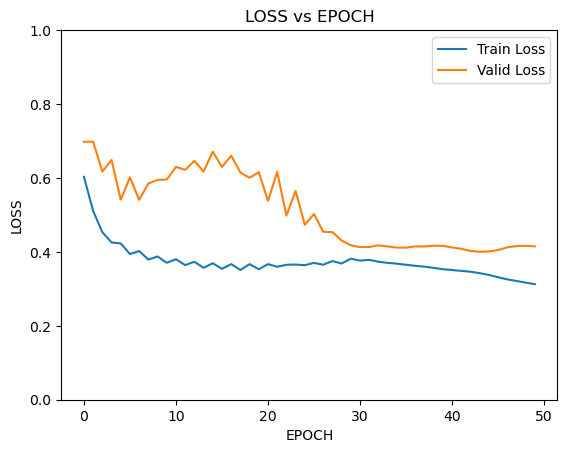

In [13]:
# loss plot
plt.plot(range(num_epoch), trains_loss, label='Train Loss')
plt.plot(range(num_epoch), valids_loss, label='Valid Loss')
plt.ylim(0.0, 1.0)
plt.title('LOSS vs EPOCH')
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.legend()
plt.show()

In [14]:
testDDDS = DetectionDataDataset("Test")
dtest_dataloader = DataLoader(testDDDS)

Test Loss: 0.4267, Accuracy: 0.8023, Precision: 0.8102, Recall: 0.8023, F1-score: 0.8001, Predict Mal: 310 / 378 / All: 789


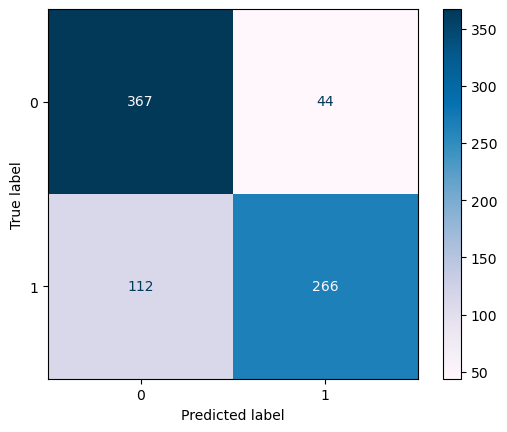

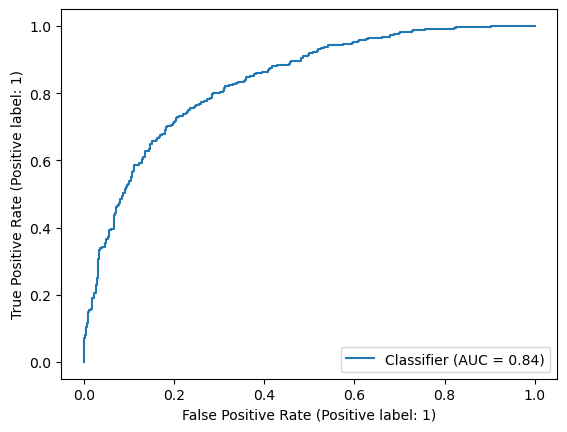

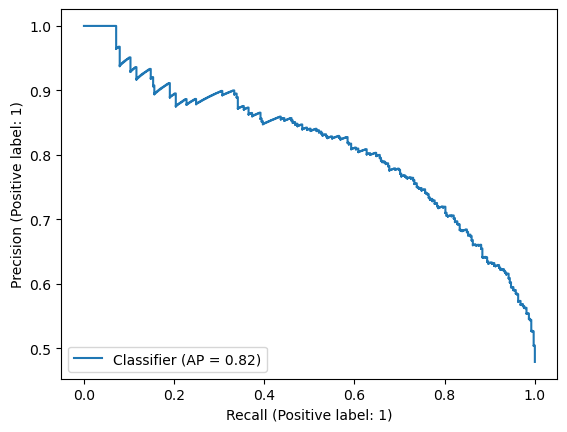

In [15]:
dmodel_best = ResidualNetwork18(in_channels=2, out_channels=8)
# dmodel_best = MyCNN(in_channels=2, out_channels=8)
dmodel_best.load_state_dict(torch.load('classification_ResNet_DD.pth'))

dmodel_best.eval()
dmodel_best.to(device)
dloss_fn = nn.CrossEntropyLoss()
# dsoftmax = nn.Softmax(dim=1)
dsigmoid = nn.Sigmoid()
dtest_true_labels = []
dtest_class_preds = []
dtest_prob_preds = []
dtest_loss_record = []
for x, y in dtest_dataloader:
    x, y = x.to(device), y.to(device)
    with torch.no_grad():
        pred = dmodel_best(x)
        loss = dloss_fn(pred, y)
        # loss = torchvision.ops.sigmoid_focal_loss(pred, y.float(), reduction='mean')

        # print(f'for {i} pred: {pred}\n')
        # print(f'for {i} label_t: {y}\n')
        dtest_true_labels.extend(y.cpu().numpy())
        dtest_loss_record.append(loss.item())
        dtest_class_preds.extend(np.argmax(pred.cpu().numpy(), axis=1))
        dtest_prob_preds.extend(dsigmoid(pred).cpu().numpy()[:,1])
        # dtest_prob_preds.extend(pred.cpu().numpy()[:,1])
        # dtest_preds.extend(np.round(sigmoid(pred).cpu().detach().numpy()))

mean_dtest_loss = sum(dtest_loss_record) / len(dtest_loss_record)
dtest_accuracy = accuracy_score(dtest_true_labels, dtest_class_preds)
dtest_precision = precision_score(dtest_true_labels, dtest_class_preds, average='weighted')
# dtest_precision = precision_score(dtest_true_labels, dtest_class_preds)
dtest_recall = recall_score(dtest_true_labels, dtest_class_preds, average='weighted')
dtest_f1score = f1_score(dtest_true_labels, dtest_class_preds, average='weighted')
print(f'Test Loss: {mean_dtest_loss:.4f}, Accuracy: {dtest_accuracy:.4f}, Precision: {dtest_precision:.4f}, Recall: {dtest_recall:.4f}, F1-score: {dtest_f1score:.4f}, Predict Mal: {sum(dtest_class_preds)} / {sum(dtest_true_labels)} / All: {len(dtest_true_labels)}')

ConfusionMatrixDisplay.from_predictions(dtest_true_labels, dtest_class_preds, cmap="PuBu")
RocCurveDisplay.from_predictions(dtest_true_labels, dtest_prob_preds)
PrecisionRecallDisplay.from_predictions(dtest_true_labels, dtest_prob_preds)
plt.show()